In [ ]:
import lightning as L
from PIL import Image
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from matplotlib import pyplot as plt
from lightning.pytorch.loggers import CSVLogger
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
from torch.nn import functional as F
from torch import nn
import geopandas as gpd
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix
import seaborn as sns
import sklearn


# Load Crown Data

In [2]:
#Load the crown polygons
crowns_df = gpd.read_file('data/tree_crowns_subset.gpkg')

# Map class labels to binary values
label_mapping = {'coniferous': 0, 'deciduous': 1}
crowns_df['label'] = crowns_df['species_type'].map(label_mapping)

#Set data dir
img_dir = 'data/clipped_crowns'
img_fpaths = list(Path(img_dir).glob("*.png"))

#Convert fpaths ls to data frame
img_df = pd.DataFrame(img_fpaths, columns=['fpath'])
img_df['crown_id'] = img_df['fpath'].apply(lambda x: int(x.stem.split(".")[0].split("_")[1]))

#Join with crowns_df
crowns_df = crowns_df.merge(img_df, on='crown_id', how='left')
crowns_df   


,label,common_name,scientific_name,genus,crown_id,species_type,minx,miny,maxx,maxy,geometry,fpath
0,0,Balsam fir,Abies balsamea,Pinaceae,8340,coniferous,577189.0365,5.093486e+06,577192.0568,5.093488e+06,"MULTIPOLYGON (((577191.446 5093488.217, 577191...",data\clipped_crowns\crown_8340.png
1,0,Balsam fir,Abies balsamea,Pinaceae,9399,coniferous,576957.3289,5.093309e+06,576960.9351,5.093313e+06,"MULTIPOLYGON (((576958.412 5093313.133, 576958...",data\clipped_crowns\crown_9399.png
2,0,Balsam fir,Abies balsamea,Pinaceae,2458,coniferous,577064.1428,5.093336e+06,577066.9213,5.093339e+06,"MULTIPOLYGON (((577066.056 5093338.765, 577065...",data\clipped_crowns\crown_2458.png
3,0,Balsam fir,Abies balsamea,Pinaceae,2492,coniferous,577052.4109,5.093352e+06,577054.2873,5.093355e+06,"MULTIPOLYGON (((577054.098 5093354.535, 577054...",data\clipped_crowns\crown_2492.png
4,0,Balsam fir,Abies balsamea,Pinaceae,567,coniferous,577186.6727,5.093215e+06,577191.7753,5.093218e+06,"MULTIPOLYGON (((577190.923 5093217.595, 577190...",data\clipped_crowns\crown_567.png
...,...,...,...,...,...,...,...,...,...,...,...,...
595,1,Red maple,Acer rubrum,Sapindaceae,54,deciduous,577088.2029,5.093114e+06,577093.3687,5.093119e+06,"MULTIPOLYGON (((577090.925 5093119.305, 577090...",data\clipped_crowns\crown_54.png
596,1,Red maple,Acer rubrum,Sapindaceae,1327,deciduous,577074.5608,5.093307e+06,577076.5100,5.093309e+06,"MULTIPOLYGON (((577076.149 5093308.862, 577076...",data\clipped_crowns\crown_1327.png
597,1,Red maple,Acer rubrum,Sapindaceae,6126,deciduous,577308.0109,5.093633e+06,577310.8445,5.093635e+06,"MULTIPOLYGON (((577310.509 5093634.769, 577310...",data\clipped_crowns\crown_6126.png
598,1,Red maple,Acer rubrum,Sapindaceae,5284,deciduous,577443.5990,5.093582e+06,577452.3151,5.093589e+06,"MULTIPOLYGON (((577448.862 5093588.134, 577448...",data\clipped_crowns\crown_5284.png


## Set up the Dataset

In [3]:
class TreeCrownDataset(Dataset):
    def __init__(self, crowns_df, split, target_res=256, train_augmentations=[]):
        self.target_res = target_res
        self.split = split
        self.crowns_df = crowns_df
        self.train_augmentations = train_augmentations

        # Create a transform to resize and normalize the crown images
        self.transforms = [
            transforms.Resize((target_res, target_res)),
            transforms.ToTensor(),
        ]
        
        #Add additional transforms for data augmentation if using train dataset
        if self.split == 'train':
            self.transforms.extend(self.train_augmentations)
           
        # Build transform pipeline
        self.transforms = transforms.Compose(self.transforms)


    def __len__(self):
        return len(self.crowns_df)

    def __getitem__(self, idx):

        target_crown = self.crowns_df.iloc[idx]

        label = torch.tensor(target_crown['label']).long()

        crown_img = Image.open(target_crown['fpath']).convert('RGB')
        
        crown_tensor = self.transforms(crown_img)

        crown_id = target_crown['crown_id']
        
        return crown_tensor, label, crown_id

## Set up the Lightning Data Module

In [4]:
class TreeCrownDataModule(L.LightningDataModule):
    def __init__(self, crowns_df, batch_size=32, train_augmentations=[]):
        super().__init__()
        self.crowns_df = crowns_df
        self.batch_size = batch_size

    def setup(self, stage=None):

        #Split data into three dataframes for train/val/test 
        train_val_df, self.test_df = train_test_split(self.crowns_df, 
                                                      test_size=0.15, 
                                                      random_state=42)
        
        self.train_df, self.val_df = train_test_split(train_val_df, 
                                                      test_size=0.17, 
                                                      random_state=42)

        #Report dataset sizes
        for name, df in [("Train", self.train_df), 
                         ("Val", self.val_df), 
                         ("Test", self.test_df)]:
            
            print(f"{name} dataset size: {len(df)}", 
                  f"({round(len(df)/len(crowns_df)*100, 0)}%)")
        
        # Instantiate datasets
        self.train_dataset = TreeCrownDataset(self.train_df, split='train')
        
        self.val_dataset = TreeCrownDataset(self.val_df, split='val')
        
        self.test_dataset = TreeCrownDataset(self.test_df, split='test')

    def train_dataloader(self):
        return DataLoader(self.train_dataset, 
                          batch_size=self.batch_size, 
                          shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, 
                          batch_size=self.batch_size, 
                          shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.test_dataset,
                          batch_size=self.batch_size, 
                          shuffle=False
                          )

#Set the training data augmentations
train_augmentations = [
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation([-90, 90]),
                transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0))
                ]

# Test the datamodule
crowns_datamodule = TreeCrownDataModule(crowns_df, train_augmentations=[])
crowns_datamodule.setup()

# Test loading a sample
sample = crowns_datamodule.train_dataset[0]
print(sample[0].shape)
print(sample[1])

Train dataset size: 423 (70.0%)
Val dataset size: 87 (14.0%)
Test dataset size: 90 (15.0%)
torch.Size([3, 256, 256])
tensor(0)


## Set up the model

In [11]:
class CNN(L.LightningModule):
    def __init__(self, lr):
        super(CNN, self).__init__()

        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)

        # Modify the final fc layer of model to output a single value for binary classification
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)

        #Add sigmoid activation to the end model
        self.model = nn.Sequential(self.model, nn.Sigmoid())

        self.criterion = nn.BCELoss()
        
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self(x).squeeze()
        loss = self.criterion(y_hat, y.float())
        self.log('train_loss', loss, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self(x).squeeze()
        loss = self.criterion(y_hat, y.float())
        self.log('val_loss', loss, on_epoch=True, on_step=False)
        return loss
    
    def predict_step(self, batch, batch_idx):
        x, y, id = batch
        y_hat = self(x).squeeze()

        return y_hat, y, id

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

#Instantiate the model with 1 class (present/absent)
model = CNN(lr=0.0001)
print(model)

CNN(
  (model): Sequential(
    (0): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
   

In [12]:
#Try passing some data through the model
batch, labels, ids = next(iter(crowns_datamodule.train_dataloader()))

# Pass batch through the model
y_hat = model(batch)

print("\nCrown IDs:\n", ids)

print("\nImage batch shape:\n", batch.shape)

print("\nOutput tensor shape:\n", y_hat.shape)

#View the predicted class probabilities
print("\nPredicted class probabilities:\n",
      y_hat.detach().cpu().numpy().squeeze())


Crown IDs:
 tensor([5742, 9317, 7197, 7069, 5691, 7359, 7750, 3901, 2532, 7842, 6923, 6985,
        2170, 1797, 3239, 2280,  995, 9405, 1707, 4205,  833, 5971, 6792, 6979,
        8618, 5435, 6957, 1211, 5732, 1608, 7108, 7882])

Image batch shape:
 torch.Size([32, 3, 256, 256])

Output tensor shape:
 torch.Size([32, 1])

Predicted class probabilities:
 [0.46629983 0.4402257  0.5045173  0.543468   0.4747245  0.5390379
 0.5344582  0.41352314 0.48769033 0.47834277 0.51337534 0.4778641
 0.50550973 0.48620906 0.48314562 0.47039393 0.44801846 0.49749184
 0.47837096 0.52830297 0.45109063 0.47504905 0.4873269  0.4804881
 0.50949365 0.47308537 0.47399345 0.48987284 0.4906782  0.42038634
 0.46694916 0.46906492]


## Set up the trainer

In [13]:
logger = CSVLogger('', name='logs', version=0)
trainer = L.Trainer(max_epochs=10, logger=logger, devices=1)
trainer.fit(model, datamodule=crowns_datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
d:\Sync\DRI-EDIA-F4A\.venv\lib\site-packages\lightning\fabric\loggers\csv_logs.py:268: Experiment logs directory logs\version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
d:\Sync\DRI-EDIA-F4A\.venv\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory logs\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Train dataset size: 423 (70.0%)
Val dataset size: 87 (14.0%)
Test dataset size: 90 (15.0%)



  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 23.5 M | train
1 | criterion | BCELoss    | 0      | train
-------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.040    Total estimated model params size (MB)
154       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\Sync\DRI-EDIA-F4A\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
d:\Sync\DRI-EDIA-F4A\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
d:\Sync\DRI-EDIA-F4A\.venv\lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [14]:
# Read the logs CSV file after training
logs_df = pd.read_csv(logger.log_dir + '/metrics.csv')
logs_df = logs_df.groupby('epoch').mean()  # merge the train and valid rows
logs_df['epoch'] = logs_df.index  # because "Epoch" gets turned into the index
logs_df.index.name = ''  # to remove the name "Epoch" from the index

# Display the logs
print(logs_df)

    step  train_loss  val_loss  epoch
                                     
0   13.0    0.608598  0.525944      0
1   27.0    0.357555  0.337478      1
2   41.0    0.208165  0.286583      2
3   55.0    0.104514  0.190760      3
4   69.0    0.043252  0.200814      4
5   83.0    0.030254  0.154026      5
6   97.0    0.031484  0.235770      6
7  111.0    0.014625  0.267709      7
8  125.0    0.009877  0.212018      8
9  139.0    0.011629  0.159658      9


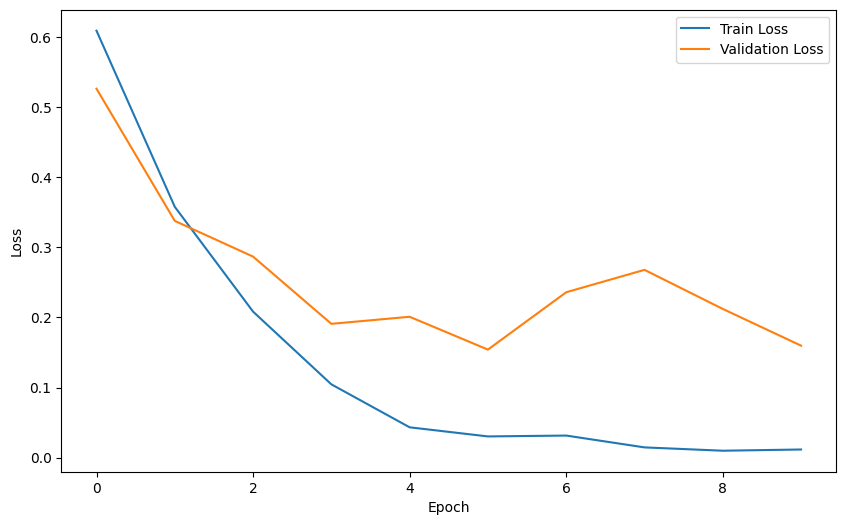

In [15]:
#Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(logs_df['train_loss'], label='Train Loss')
plt.plot(logs_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
#Test the model on the test set
out = trainer.predict(model, datamodule=crowns_datamodule, return_predictions=True)

# Separate predictions and targets from output
pred_class_probs = np.concatenate([batch[0] for batch in out])
obs = np.concatenate([batch[1] for batch in out])
ids = np.concatenate([batch[2] for batch in out])

#Convert to obs-pred dataframe
test_df = pd.DataFrame({'obs': obs, 'pred_class_probs': pred_class_probs, 'crown_id': ids})

#Convert class probabilities to binary predictions
test_df['pred_boolean_class'] = (test_df['pred_class_probs'] > 0.5)

#Convert binary predictions to integers
test_df['pred'] = test_df['pred_boolean_class'].astype(int)

#Add a column for correct/incorrect predictions
test_df['correct'] = test_df['obs'] == test_df['pred']

#Join with crowns_df
test_df = test_df.merge(crowns_df, on='crown_id', how='left')
test_df

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Train dataset size: 423 (70.0%)
Val dataset size: 87 (14.0%)
Test dataset size: 90 (15.0%)


d:\Sync\DRI-EDIA-F4A\.venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

,obs,pred_class_probs,crown_id,pred_boolean_class,pred,correct,label,common_name,scientific_name,genus,species_type,minx,miny,maxx,maxy,geometry,fpath
0,0,0.005484,6255,False,0,True,0,Balsam fir,Abies balsamea,Pinaceae,coniferous,577280.4300,5.093567e+06,577283.6100,5.093571e+06,"MULTIPOLYGON (((577283.094 5093570.229, 577283...",data\clipped_crowns\crown_6255.png
1,1,0.999810,4976,True,1,True,1,Paper birch,Betula papyrifera,Betulaceae,deciduous,577511.8384,5.093631e+06,577517.9060,5.093637e+06,"MULTIPOLYGON (((577514.633 5093636.637, 577514...",data\clipped_crowns\crown_4976.png
2,1,0.993215,4013,True,1,True,1,Red maple,Acer rubrum,Sapindaceae,deciduous,577290.7698,5.093369e+06,577298.8473,5.093377e+06,"MULTIPOLYGON (((577298.717 5093373.531, 577298...",data\clipped_crowns\crown_4013.png
3,0,0.012895,1630,False,0,True,0,Balsam fir,Abies balsamea,Pinaceae,coniferous,577281.3665,5.093269e+06,577283.9365,5.093271e+06,"MULTIPOLYGON (((577283.238 5093268.974, 577283...",data\clipped_crowns\crown_1630.png
4,0,0.636034,2257,True,1,False,0,Eastern white cedar,Thuja occidentalis,Cupressaceae,coniferous,577034.8737,5.093300e+06,577039.7978,5.093305e+06,"MULTIPOLYGON (((577038.579 5093303.81, 577038....",data\clipped_crowns\crown_2257.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0,0.116941,1548,False,0,True,0,Balsam fir,Abies balsamea,Pinaceae,coniferous,577182.6959,5.093241e+06,577184.6524,5.093244e+06,"MULTIPOLYGON (((577184.652 5093242.66, 577184....",data\clipped_crowns\crown_1548.png
86,0,0.030834,7638,False,0,True,0,Eastern white cedar,Thuja occidentalis,Cupressaceae,coniferous,577128.5237,5.093460e+06,577132.4866,5.093463e+06,"MULTIPOLYGON (((577132.487 5093461.843, 577132...",data\clipped_crowns\crown_7638.png
87,0,0.003246,9203,False,0,True,0,Eastern white cedar,Thuja occidentalis,Cupressaceae,coniferous,576947.2546,5.093326e+06,576949.9117,5.093329e+06,"MULTIPOLYGON (((576947.414 5093328.033, 576947...",data\clipped_crowns\crown_9203.png
88,1,0.931758,6041,True,1,True,1,Paper birch,Betula papyrifera,Betulaceae,deciduous,577351.3744,5.093488e+06,577357.8790,5.093495e+06,"MULTIPOLYGON (((577355.869 5093494.907, 577355...",data\clipped_crowns\crown_6041.png


In [17]:
#Calculate overall accuracy using sklearn
overall_acc = sklearn.metrics.accuracy_score(y_true=test_df['obs'], y_pred=test_df['pred'])
print(f"Overall accuracy: {overall_acc:.2f}")

#Check how many crowns were classified correctly
n_correct = len(test_df[test_df['correct'] == True])

print(f"Summary: {n_correct} / {len(test_df)} crowns were classified correctly.")

Overall accuracy: 0.92
Summary: 83 / 90 crowns were classified correctly.


{'coniferous': 0, 'deciduous': 1}


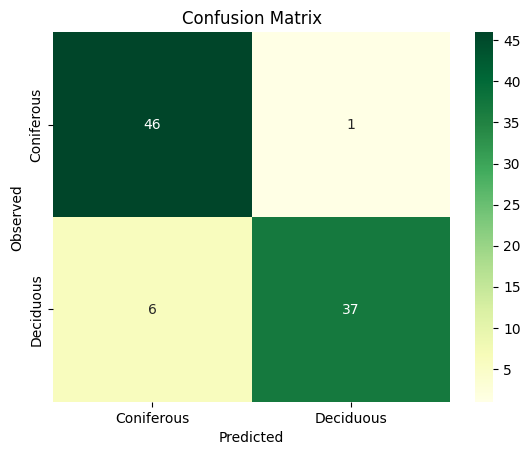

In [18]:
print(label_mapping)

#Generate a confusion matrix using seaborn
cm = confusion_matrix(y_true=test_df['obs'], 
                      y_pred=test_df['pred'])

#Plot the confusion matrix
classes = ['Coniferous', 'Deciduous']
sns.heatmap(cm, annot=True, 
            cmap='YlGn', 
            xticklabels=classes, 
            yticklabels=classes)


plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.title('Confusion Matrix')
plt.show()




Incorrectly classified coniferous crowns.



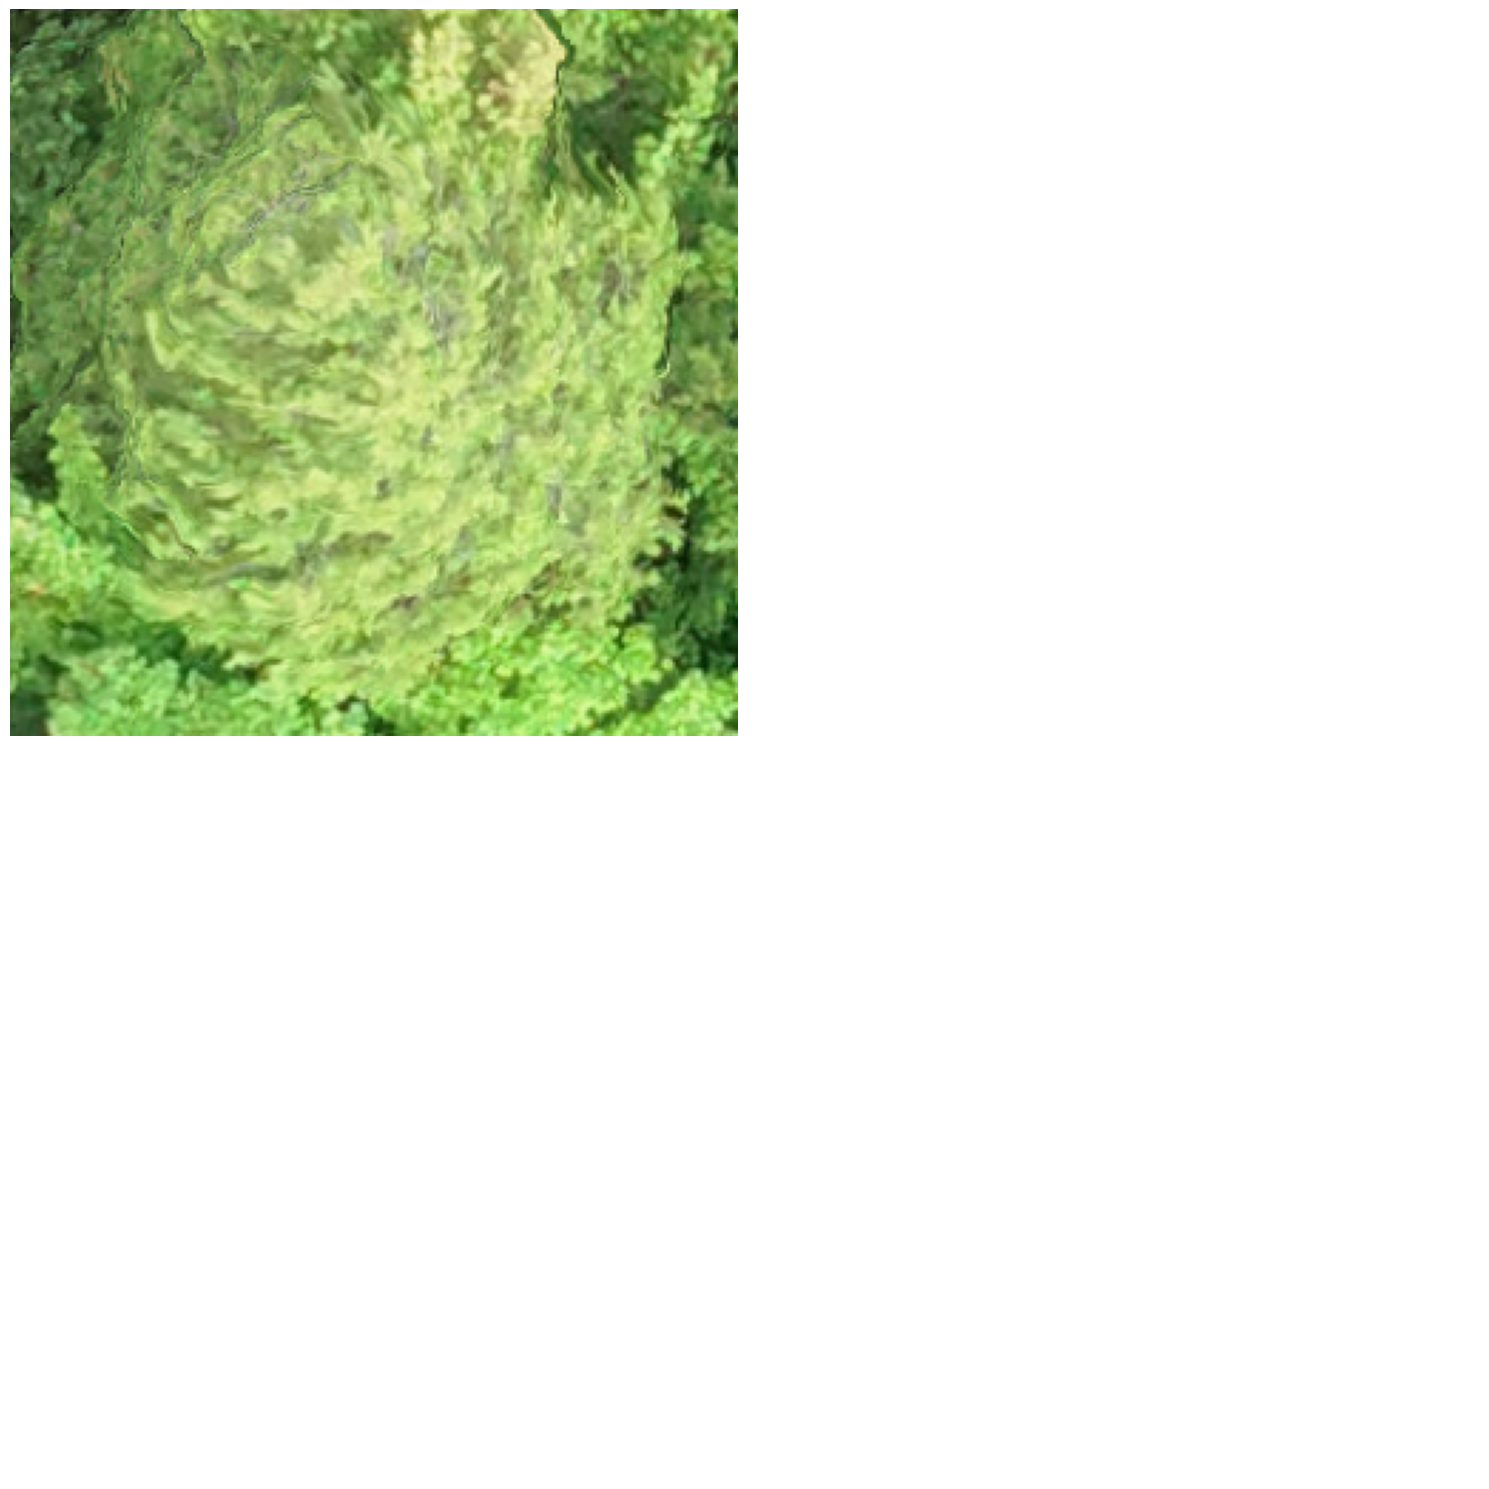


Incorrectly classified deciduous crowns.



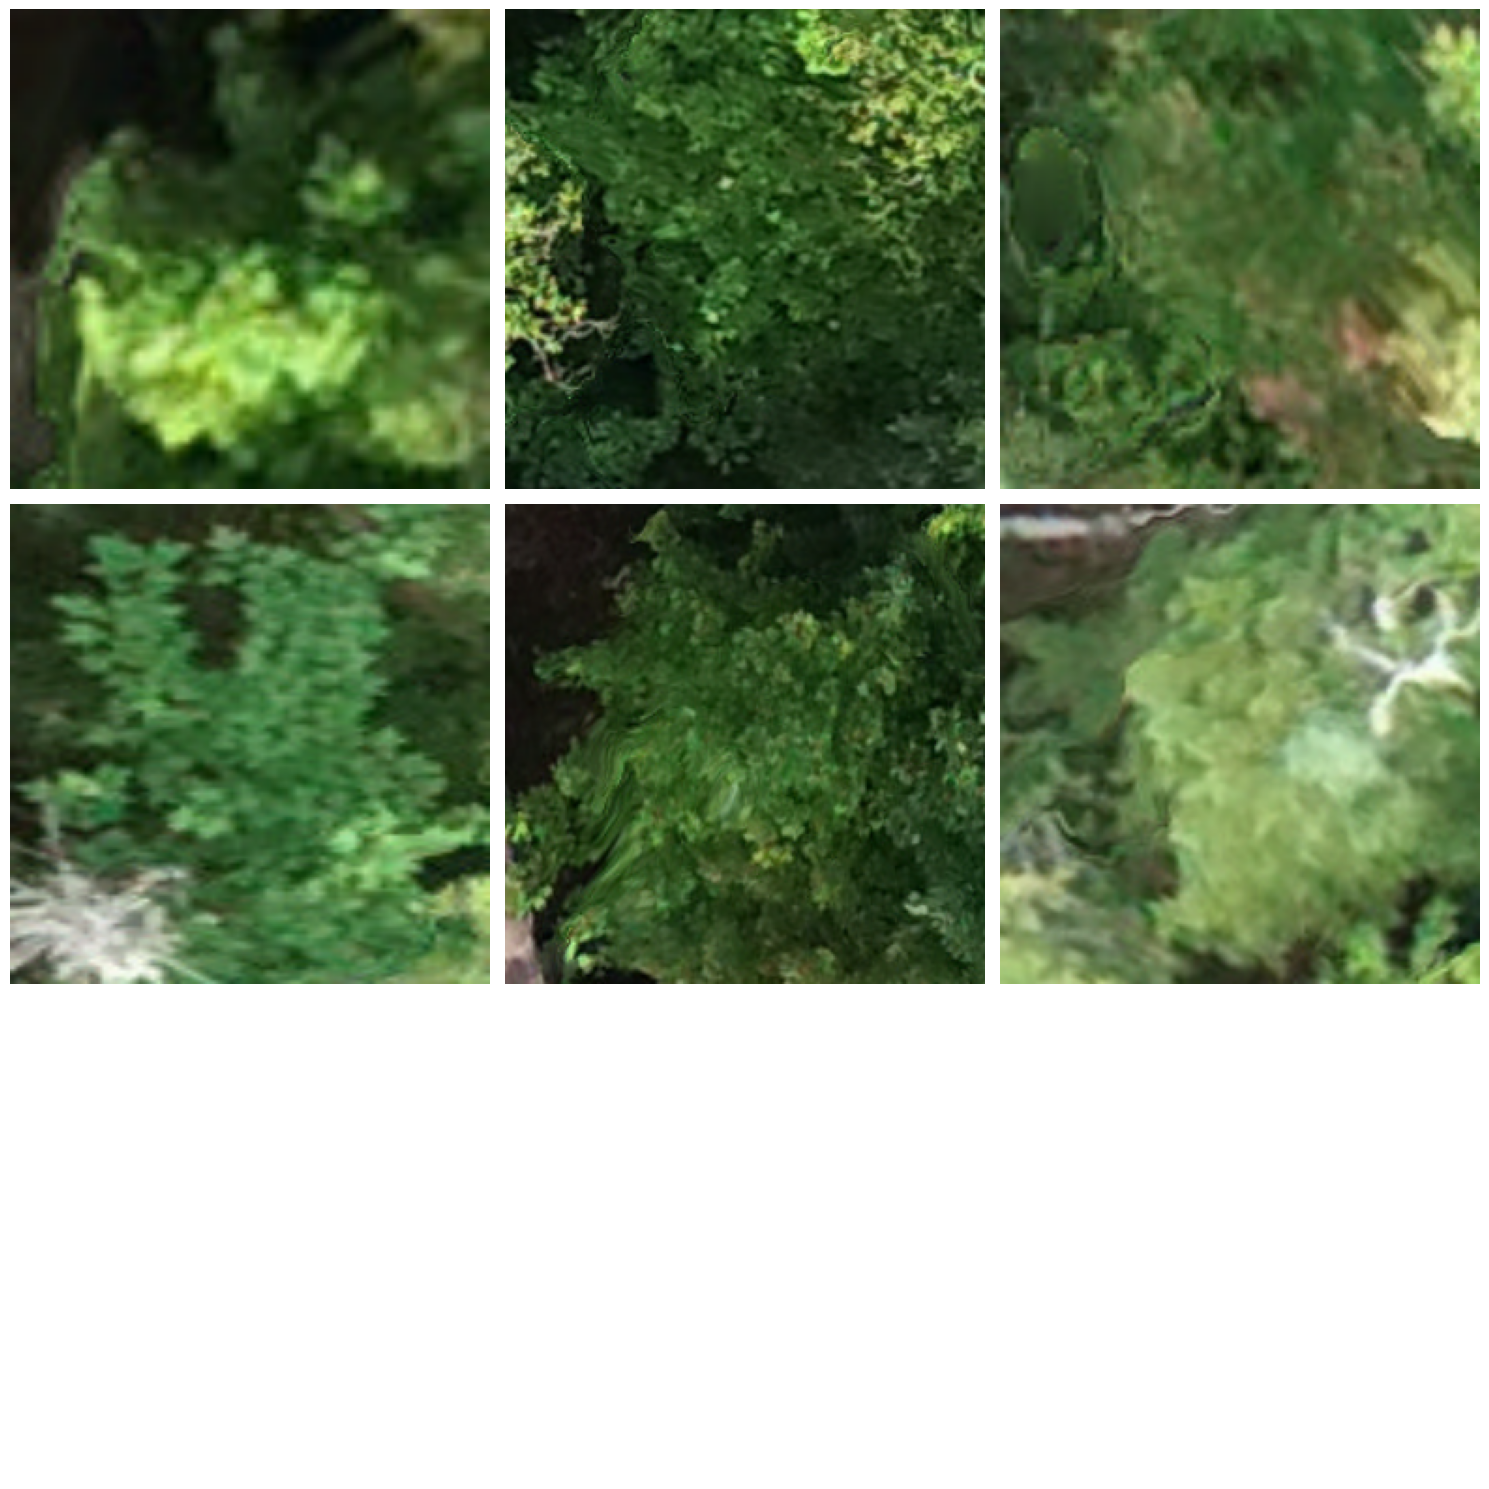

In [19]:
# Let's view the incorrectly classified crowns
incorrect_df = test_df[test_df['correct'] == False]

#Plot incorrecty classified coniferous/deciduous crowns

for c_type in test_df['species_type'].unique():

    print(f"\nIncorrectly classified {c_type} crowns.\n")

    # Filter the incorrect crowns by species type
    incorrect_type_df = test_df[(test_df['correct'] == False) & (test_df['species_type'] == c_type)]

    # Number of images
    num_images = len(incorrect_type_df)

    # Determine the grid size
    grid_size = int(num_images**0.5) + 1

    # Create a figure and axes
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Read the incorrect crown files and plot them
    for ax, fpath in zip(axes, incorrect_type_df['fpath']):
        img = Image.open(fpath)
        ax.imshow(img)
        ax.axis('off')

    # Hide any remaining empty subplots
    for ax in axes[num_images:]:
        ax.axis('off')

    plt.tight_layout()

    plt.show()